In [1]:
from collections import OrderedDict
import pathlib
from fuse.utils.utils_logger import fuse_logger_start
import os
import sys
# add parent directory to path, so that 'baseline' folder is treated as a module
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("__file__")), '..'))
from baseline.dataset import knight_dataset
import pandas as pd
from fuse.models.model_default import FuseModelDefault
from fuse.models.backbones.backbone_resnet_3d import FuseBackboneResnet3D
from fuse.models.heads.head_3D_classifier import FuseHead3dClassifier
from fuse.losses.loss_default import FuseLossDefault
import torch.nn.functional as F
import torch.nn as nn
from fuse.eval.metrics.classification.metrics_classification_common import MetricAUCROC, MetricAccuracy, MetricConfusion
from fuse.eval.metrics.classification.metrics_thresholding_common import MetricApplyThresholds
import torch.optim as optim
from fuse.managers.manager_default import FuseManagerDefault
from fuse.managers.callbacks.callback_tensorboard import FuseTensorboardCallback
from fuse.managers.callbacks.callback_metric_statistics import FuseMetricStatisticsCallback
from fuse.utils.utils_gpu import FuseUtilsGPU
from fuse.utils.utils_misc import FuseUtilsMisc
import logging
import time

import SimpleITK as sitk
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
import torch
import matplotlib.pyplot as plt



/projects/msieve_dev3/usr/il018850/tools/miniconda3/envs/fuse_pub/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# spacings = []
# sizes = []
shapes = []
for i in range(300):
    print(i)
    data_itk = sitk.ReadImage(f"/projects/msieve/MedicalSieve/PatientData/KNIGHT/knight/data/case_{i:05d}/imaging.nii.gz")
    # spacings.append(data_itk.GetSpacing())
    # sizes.append(data_itk.GetSize())
    spacing = np.array(data_itk.GetSpacing())[([1,2,0])]
    data_npy = np.expand_dims(sitk.GetArrayFromImage(data_itk).astype(np.float32), axis=0)
    data, _ = resample_patient(data_npy,None,  spacing, (0.78125, 0.78125, 2.5     ),force_separate_z=True )
    shapes.append(data.shape)
    print(data.shape)


0
[0 1]
no separate z, order 3
(1, 603, 603, 122)
1
[0 1]
no separate z, order 3
(1, 524, 524, 120)
2
[2]
separate z, order in z is 0 order inplane is 3
(1, 616, 616, 104)
3
[2]
separate z, order in z is 0 order inplane is 3
(1, 561, 561, 108)
4
[2]
separate z, order in z is 0 order inplane is 3
(1, 640, 640, 102)
5
[0 1]
no separate z, order 3
(1, 640, 640, 167)
6
[2]
separate z, order in z is 0 order inplane is 3
(1, 486, 486, 188)
7
[2]
separate z, order in z is 0 order inplane is 3
(1, 616, 616, 73)
8
[2]
separate z, order in z is 0 order inplane is 3
(1, 535, 535, 272)
9
[2]
separate z, order in z is 0 order inplane is 3
(1, 530, 530, 92)
10
[2]
separate z, order in z is 0 order inplane is 3
(1, 497, 497, 60)
11
[2]
separate z, order in z is 0 order inplane is 3
(1, 461, 461, 160)
12
[2]
separate z, order in z is 0 order inplane is 3
(1, 493, 493, 178)
13
[2]
separate z, order in z is 0 order inplane is 3
(1, 448, 448, 110)
14
[2]
separate z, order in z is 0 order inplane is 3
(1,

In [22]:
shapes = np.array(shapes)
print(np.median(shapes, axis=0))
print(np.max(shapes, axis=0))
print(np.min(shapes, axis=0))

[  1. 512. 512. 165.]
[  1 682 682 575]
[  1 287 287  57]


In [2]:
i = 1
data_itk = sitk.ReadImage(f"/projects/msieve/MedicalSieve/PatientData/KNIGHT/knight/data/case_{i:05d}/imaging.nii.gz")
seg_itk = sitk.ReadImage(f"/projects/msieve/MedicalSieve/PatientData/kits21/kits21/data/case_{i:05d}/aggregated_MAJ_seg.nii.gz")
data_npy = sitk.GetArrayFromImage(data_itk).astype(np.float32)

data_npy.shape

(512, 512, 602)

In [3]:
seg_npy = sitk.GetArrayFromImage(seg_itk).astype(np.float32)
seg_npy.shape

(512, 512, 602)

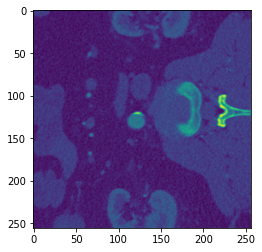

In [6]:
from fuse.data.augmentor.augmentor_toolbox import aug_op_random_crop_and_pad

cropped = aug_op_random_crop_and_pad(torch.tensor(data_npy),(256,256,110), 0, centralize=True)
plt.imshow(cropped[:,:,80])

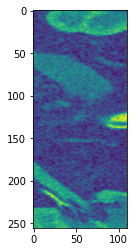

In [7]:
plt.imshow(cropped[:,110,:])

In [54]:
data_itk.GetSpacing()

(0.5, 0.751953125, 0.751953125)

In [59]:
data.shape

(1, 493, 493, 104)

In [15]:
from skimage.transform import resize
def resample_patient(data, seg, original_spacing, target_spacing, order_data=3, order_seg=0, force_separate_z=False,
                     order_z_data=0, order_z_seg=0,
                     separate_z_anisotropy_threshold=3):
    """
    :param data:
    :param seg:
    :param original_spacing:
    :param target_spacing:
    :param order_data:
    :param order_seg:
    :param force_separate_z: if None then we dynamically decide how to resample along z, if True/False then always
    /never resample along z separately
    :param order_z_seg: only applies if do_separate_z is True
    :param order_z_data: only applies if do_separate_z is True
    :param separate_z_anisotropy_threshold: if max_spacing > separate_z_anisotropy_threshold * min_spacing (per axis)
    then resample along lowres axis with order_z_data/order_z_seg instead of order_data/order_seg
    :return:
    """
    assert not ((data is None) and (seg is None))
    if data is not None:
        assert len(data.shape) == 4, "data must be c x y z"
    if seg is not None:
        assert len(seg.shape) == 4, "seg must be c x y z"

    if data is not None:
        shape = np.array(data[0].shape)
    else:
        shape = np.array(seg[0].shape)
    new_shape = np.round(((np.array(original_spacing) / np.array(target_spacing)).astype(float) * shape)).astype(int)

    if force_separate_z is not None:
        do_separate_z = force_separate_z
        if force_separate_z:
            axis = get_lowres_axis(original_spacing)
        else:
            axis = None
    else:
        if get_do_separate_z(original_spacing, separate_z_anisotropy_threshold):
            do_separate_z = True
            axis = get_lowres_axis(original_spacing)
        elif get_do_separate_z(target_spacing, separate_z_anisotropy_threshold):
            do_separate_z = True
            axis = get_lowres_axis(target_spacing)
        else:
            do_separate_z = False
            axis = None

    if axis is not None:
        if len(axis) == 3:
            # every axis has the spacing, this should never happen, why is this code here?
            do_separate_z = False
        elif len(axis) == 2:
            # this happens for spacings like (0.24, 1.25, 1.25) for example. In that case we do not want to resample
            # separately in the out of plane axis
            do_separate_z = False
        else:
            pass

    if data is not None:
        data_reshaped = resample_data_or_seg(data, new_shape, False, axis, order_data, do_separate_z,
                                             order_z=order_z_data)
    else:
        data_reshaped = None
    if seg is not None:
        seg_reshaped = resample_data_or_seg(seg, new_shape, True, axis, order_seg, do_separate_z, order_z=order_z_seg)
    else:
        seg_reshaped = None
    return data_reshaped, seg_reshaped

def resample_data_or_seg(data, new_shape, is_seg=False, axis=None, order=3, do_separate_z=False, order_z=0):
    """
    separate_z=True will resample with order 0 along z
    :param data:
    :param new_shape:
    :param is_seg:
    :param axis:
    :param order:
    :param do_separate_z:
    :param order_z: only applies if do_separate_z is True
    :return:
    """
    assert len(data.shape) == 4, "data must be (c, x, y, z)"
    assert len(new_shape) == len(data.shape) - 1
    if is_seg:
        resize_fn = resize_segmentation
        kwargs = OrderedDict()
    else:
        resize_fn = resize
        kwargs = {'mode': 'edge', 'anti_aliasing': False}
    dtype_data = data.dtype
    shape = np.array(data[0].shape)
    new_shape = np.array(new_shape)
    if np.any(shape != new_shape):
        data = data.astype(float)
        if do_separate_z:
            print("separate z, order in z is", order_z, "order inplane is", order)
            assert len(axis) == 1, "only one anisotropic axis supported"
            axis = axis[0]
            if axis == 0:
                new_shape_2d = new_shape[1:]
            elif axis == 1:
                new_shape_2d = new_shape[[0, 2]]
            else:
                new_shape_2d = new_shape[:-1]

            reshaped_final_data = []
            for c in range(data.shape[0]):
                reshaped_data = []
                for slice_id in range(shape[axis]):
                    if axis == 0:
                        reshaped_data.append(resize_fn(data[c, slice_id], new_shape_2d, order, **kwargs).astype(dtype_data))
                    elif axis == 1:
                        reshaped_data.append(resize_fn(data[c, :, slice_id], new_shape_2d, order, **kwargs).astype(dtype_data))
                    else:
                        reshaped_data.append(resize_fn(data[c, :, :, slice_id], new_shape_2d, order, **kwargs).astype(dtype_data))
                reshaped_data = np.stack(reshaped_data, axis)
                if shape[axis] != new_shape[axis]:

                    # The following few lines are blatantly copied and modified from sklearn's resize()
                    rows, cols, dim = new_shape[0], new_shape[1], new_shape[2]
                    orig_rows, orig_cols, orig_dim = reshaped_data.shape

                    row_scale = float(orig_rows) / rows
                    col_scale = float(orig_cols) / cols
                    dim_scale = float(orig_dim) / dim

                    map_rows, map_cols, map_dims = np.mgrid[:rows, :cols, :dim]
                    map_rows = row_scale * (map_rows + 0.5) - 0.5
                    map_cols = col_scale * (map_cols + 0.5) - 0.5
                    map_dims = dim_scale * (map_dims + 0.5) - 0.5

                    coord_map = np.array([map_rows, map_cols, map_dims])
                    if not is_seg or order_z == 0:
                        reshaped_final_data.append(map_coordinates(reshaped_data, coord_map, order=order_z,
                                                                   mode='nearest')[None].astype(dtype_data))
                    else:
                        unique_labels = np.unique(reshaped_data)
                        reshaped = np.zeros(new_shape, dtype=dtype_data)

                        for i, cl in enumerate(unique_labels):
                            reshaped_multihot = np.round(
                                map_coordinates((reshaped_data == cl).astype(float), coord_map, order=order_z,
                                                mode='nearest'))
                            reshaped[reshaped_multihot > 0.5] = cl
                        reshaped_final_data.append(reshaped[None].astype(dtype_data))
                else:
                    reshaped_final_data.append(reshaped_data[None].astype(dtype_data))
            reshaped_final_data = np.vstack(reshaped_final_data)
        else:
            print("no separate z, order", order)
            reshaped = []
            for c in range(data.shape[0]):
                reshaped.append(resize_fn(data[c], new_shape, order, **kwargs)[None].astype(dtype_data))
            reshaped_final_data = np.vstack(reshaped)
        return reshaped_final_data.astype(dtype_data)
    else:
        print("no resampling necessary")
        return data


def get_do_separate_z(spacing, anisotropy_threshold=3):
    do_separate_z = (np.max(spacing) / np.min(spacing)) > anisotropy_threshold
    return do_separate_z


def get_lowres_axis(new_spacing):
    axis = np.where(max(new_spacing) / np.array(new_spacing) == 1)[0]# find which axis is anisotropic
    return axis

In [18]:
spacing = np.array(data_itk.GetSpacing())[([1,2,0])]
data_npy = np.expand_dims(sitk.GetArrayFromImage(data_itk).astype(np.float32), axis=0)
data, _ = resample_patient(data_npy,None,  spacing, (0.78125, 0.78125, 3.     ),force_separate_z=True )

[2]
separate z, order in z is 0 order inplane is 3


In [19]:
data.shape

(1, 544, 544, 57)